# 1 Introduction
This notebook is for the workshop presented at the PORSEC 2025.  
This training course covers the basic handling of SGLI products using python in the following sequence.

**1. reading data from hdf5 files and converting to geophysical quantities**  
SGLI data is stored in integer values for data compression purposes. Therefore, it is necessary to convert from integer values in order to retrieve physical quantities.  

**2. Quality control of satellite data using QA flags**  
In SGLI data, a flag indicating the quality is set for each pixel. By using these flags appropriately, data of suitable quality for the intended use can be extracted.  

**3. Map projection to equirectangular coordinates**  
SGLI standard products are distributed on a non-map-projected scene basis. Therefore, a map projection is necessary to determine the difference in geophysical quantities in the area of interest between different dates (satellite orbit paths) or different satellites (MODIS or GOCI2 etc...).   

**4. Exercise. Comparison between different sensors using map progections**  
Using the map projection technique learnt up to step3, compare SGLI and MODIS Chl-a images of the same day.



# 2 Reading data from HDF5 files
## 2.1 Import sample data

In [1]:
!git clone https://github.com/tnakayama0717/PORSEC_2025

Cloning into 'PORSEC_2025'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 105 (delta 29), reused 63 (delta 18), pack-reused 27 (from 1)
Receiving objects: 100% (105/105), 191.23 MiB | 11.54 MiB/s, done.
Resolving deltas: 100% (32/32), done.
Updating files: 100% (15/15), done.


## 2.2 Import libraries
Import the hdf5 and matplotlib libraries required for map projection of SGLI images.

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable

## 2.3 Target file specification
Specify the path to the target file.
In this case, select the SST image.  
Try downloading various SGLI files from the G-portal Repo and try them out later.

In [3]:
FNAME = 'PORSEC_2025/sample_images/GC1SG1_201809050115H04610_L2SG_SSTDQ_3001.h5'

## 2.4 Check the structure of the HDF5 file
HDF5 files have a hierarchical structure which is similar to that of computers.  
However, the names of each element are different, as shown in the table below.   
<img src="https://github.com/tnakayama0717/PORSEC_2025/blob/master/figures_for_markdown/hdf%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E6%A7%8B%E9%80%A0%E6%A6%82%E8%A6%81_en.png?raw=1" width="50%">  
Check the data structure of the SGLI hdf5 file using python.

In [4]:
def PrintAllObjects(name):
    print(name)

with h5py.File(FNAME,'r') as f:
    f.visit(PrintAllObjects)

Geometry_data
Geometry_data/Latitude
Geometry_data/Longitude
Geometry_data/Obs_time
Geometry_data/Sensor_zenith
Geometry_data/Solar_zenith
Global_attributes
Image_data
Image_data/Cloud_probability
Image_data/Line_tai93
Image_data/QA_flag
Image_data/SST
Level_1_attributes
Processing_attributes


It can also be found on hdfview ( https://www.hdfgroup.org/download-hdfview/ ), which can view contents of HDF5 easily.  
<img src="https://github.com/tnakayama0717/PORSEC_2025/blob/master/figures_for_markdown/hdf%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E6%A7%8B%E9%80%A0.png?raw=1" width="50%">  

## 2.5 Dataname specification
Specify the datename you want to plot.  
The full path, including the hdf5 hierarchy group, must be properly specified.  
In particular, note that the first / is often forgotten.  
If you want to show SST, specify ‘/Image_data/SST’.  

In [5]:
DNAME = '/Image_data/SST'

## 2.6 Load data
Let's load the SST data and create a figure.

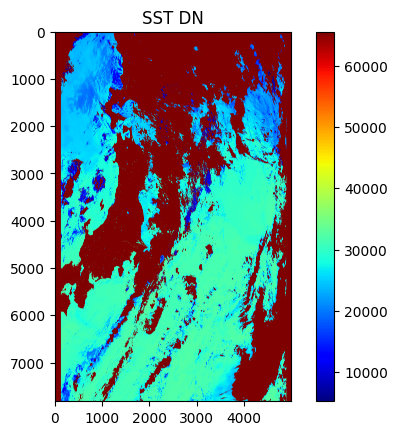

In [6]:
with h5py.File(FNAME, 'r') as file:
    # Read SST data
    Data0 = file[DNAME][:]

fig, ax = plt.subplots()
plt.imshow(Data0, cmap='jet')
ax.set_title("SST DN")
plt.colorbar()
#plt.savefig("DN.png", format="png", dpi=2000)
plt.show()

# 3 Conversion from DN to physical quantity
Each physical quantity is stored as an integer value from 0-65535 for data compression purposes (Digital Number = DN).  
To convert a DN into a physical quantity, the necessary constants must be read from the attribute associated with each physical quantity and calculated.

 ## 3.1 Checking the attribute
The attribute set for each dataset or group can be checked below.

In [7]:
with h5py.File(FNAME,'r') as file:
    dset = file[DNAME].attrs
    for k in dset.keys():
        print(k)

Cloud_error_DN
Data_description
Dim0
Dim1
Error_DN
Land_DN
Mask_for_statistics
Maximum_valid_DN
Minimum_valid_DN
Offset
Retrieval_error_DN
Slope
Spatial_resolution
Spatial_resolution_unit
Unit


Check with hdfview.    
<img src="https://github.com/tnakayama0717/PORSEC_2025/blob/master/figures_for_markdown/attribute.png?raw=1" width="100%">  

## 3.2 Conversion from DN to physical quantity
For the physical quantity conversion of SGLI data, [**slope**] and [**offset**] must be read and calculated as follows.  

$$
[physical\:quantity] = [DN] * [slope] + [offset]
$$

Also, use [**ErrorDN**] and [**Maximum_valid_DN**], [**Minimum_valid_DN**] to remove invalid pixels before DN conversion.  

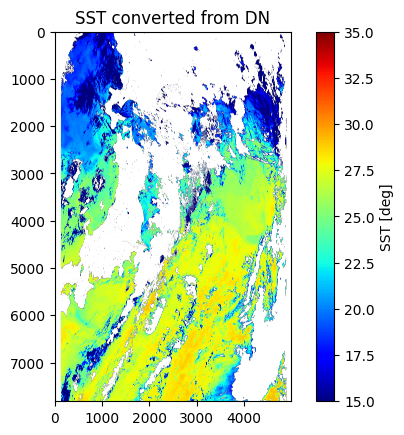

In [8]:
with h5py.File(FNAME, 'r') as file:
    # Read DN
    Data0 = file[DNAME][:]

    # Read attributes
    Err_DN = file[DNAME].attrs['Error_DN']
    Min_DN = file[DNAME].attrs['Minimum_valid_DN']
    Max_DN = file[DNAME].attrs['Maximum_valid_DN']
    Slope  = file[DNAME].attrs['Slope']
    Offset = file[DNAME].attrs['Offset']

    # Removal of invalid pixels and physical quantity conversion.
    Data1 = Data0.astype(float)
    Data1[Data0 == Err_DN] = np.nan
    Data1[(Data0 < Min_DN) | (Data0 > Max_DN)] = np.nan
    Data1 = Slope * Data1 + Offset

fig, ax = plt.subplots()
plt.imshow(Data1, cmap='jet', vmin=15, vmax=35)
ax.set_title("SST converted from DN")
plt.colorbar(label='SST [deg]')
plt.show()

Now we have successfully converted it into physical quantities, but there are obvious abnormal near by clouds.

# 4 Satellite data quality control with QA_flag
## 4.1 QA_flag overview
For SGLI data, a QA flag is set for each pixel to indicate its quality.  
Screening using the QA flag allows only data of the desired quality to be extracted.  
  
The QA flags are stored in DN (0-65535) and the flag corresponding to the value of each bit when viewed as a binary number (type uint16) is set.  
Example) 16-bit unsigned integer type: 1928 in decimal  
<img src="https://github.com/tnakayama0717/PORSEC_2025/blob/master/figures_for_markdown/bit%E8%AA%AC%E6%98%8E.png?raw=1" width="70%">   
  
Now let's check the contents of the flags corresponding to each bit of QA_flag.

In [9]:
with h5py.File(FNAME,'r') as file:
    qa_flag_data_description = file['/Image_data/QA_flag'].attrs['Data_description']
    qa_string = qa_flag_data_description.astype(str)
    qa_string = ",".join(qa_string)
    qa_string = qa_string.replace(',', '\n')
    print(qa_string)

Bit-0:invalid data
1:land
2:Rejected by QC
3:retrieval error
4:invalid data(TIR1)
5:invalid data(TIR2)
6-7:reserved
8:0:nighttime or no visible data
1:daytime
9:near land
10:cloudy
11:unknown clear/cloudy
12:possibly cloudy
 13:acceptable
14:good
15:reserved


Information on QA_flag can also be found on the official GCOM-C website.（https://suzaku.eorc.jaxa.jp/GCOM_C/data/update/Algorithm_SST_en.html)
<img src="https://github.com/tnakayama0717/PORSEC_2025/blob/master/figures_for_markdown/sst_qa_flag.png?raw=1" width="70%">

## 4.2 Making figure: Each bit of the QA_flag spatial distribution
This code loads the QA_flag data from an HDF5 file and visualizes the information for each bit within the dataset.  

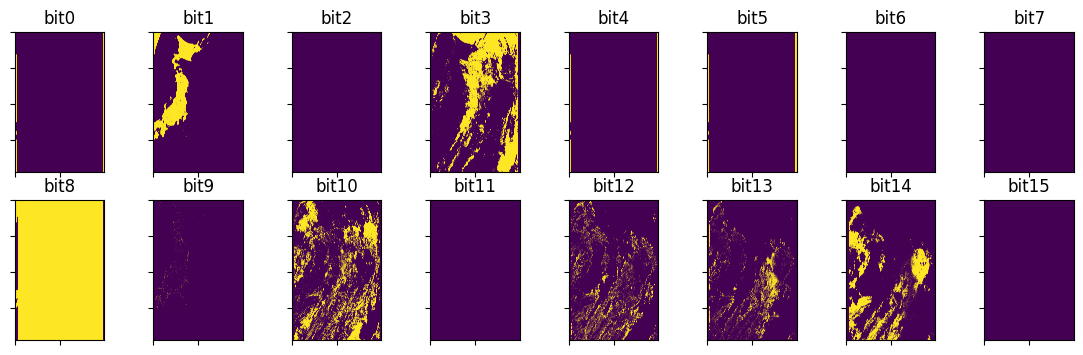

In [10]:
with h5py.File(FNAME, 'r') as file:
    QA_flag = file['/Image_data/QA_flag'][:]
    fig = plt.figure(figsize=(14.0, 4.0))
    for i in range(16):
        qa_flag_bit = np.bitwise_and(QA_flag, 2**i, dtype=np.uint16)
        ax = fig.add_subplot(2, 8, i+1)
        ax.set_title("bit"+ str(i))
        im = ax.imshow(qa_flag_bit, vmin=0, vmax=1)
        ax.tick_params(labelbottom=False, labelleft=False)

## 4.3 Applying the QA_flag
This time, let's visualize only the pixels where flags [**bit12:possibly_cloudy**], [**bit13:acceptable**], and [**bit14:good**] are set.

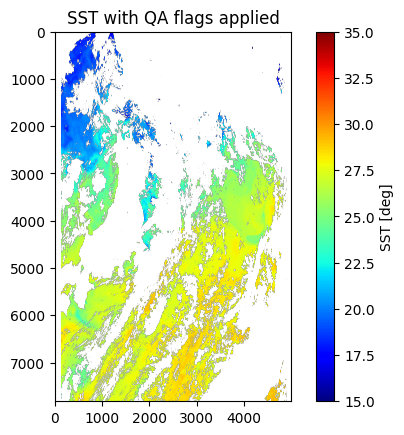

In [11]:
with h5py.File(FNAME, 'r') as file:

    # Read QA_flag
    QA_flag = file['/Image_data/QA_flag'][:]
    possibly_cloudy = np.bitwise_and(QA_flag, 2**12, dtype=np.uint16)
    acceptable = np.bitwise_and(QA_flag, 2**13, dtype=np.uint16)
    good = np.bitwise_and(QA_flag, 2**14, dtype=np.uint16)

    # Combine multiple conditions (good, acceptable, possibly_cloudy) using a logical OR operation.
    reliable = np.logical_or.reduce([good, acceptable, possibly_cloudy])

    # Apply reliability mask
    Data1[~reliable] = np.nan

    # Plotting with reliability mask
    fig, ax = plt.subplots()
    plt.imshow(Data1, cmap='jet', vmin=15, vmax=35)
    ax.set_title("SST with QA flags applied")
    plt.colorbar(label='SST [deg]')
    plt.show()

However, since missing values will naturally increase, please use the QA flags appropriately depending on the purpose.

# 5. Conversion to latitude and longitude coordinates
Polar-orbiting satellite SGLI images are provided as just they are scanned by the satellite (Scene).  
In order to map these images to latitude and longitude coordinates, a 2D interpolation must be performed to transform the coordinates.  
<img src="https://github.com/tnakayama0717/PORSEC_2025/blob/master/figures_for_markdown/SGLI_%E3%82%B9%E3%82%AD%E3%83%A3%E3%83%B3%E6%A6%82%E5%BF%B5%E5%9B%B3.png?raw=1" width="80%">


## 5.1 Reading latitude and longitude information
The SGLI latitude and longitude information is stored in 10-pix thinning (Resampling_interval), so it must first be interpolated to the same resolution as the physical quantity.
<img src="https://github.com/tnakayama0717/PORSEC_2025/blob/master/figures_for_markdown/%E7%B7%AF%E5%BA%A6%E7%B5%8C%E5%BA%A6%E5%86%85%E6%8C%BF%E6%89%8B%E6%B3%95.png?raw=1" width="80%">


<ipython-input-12-752d018dabc0>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Lat_r = float(file['/Geometry_data/Latitude'].attrs['Resampling_interval'])
<ipython-input-12-752d018dabc0>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Lon_r = float(file['/Geometry_data/Longitude'].attrs['Resampling_interval'])


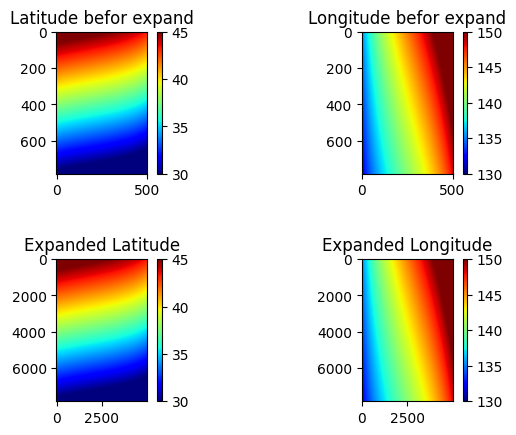

In [12]:
#Due to the RAM usage limit in Google Colab, we will perform the interpolation process in several chunks this time.
chunk_size = 1000  # Chunk size for rows

with h5py.File(FNAME, 'r') as file:
    Data0_shape = file[DNAME].shape
    Lat_shape = file['/Geometry_data/Latitude'].shape
    Lon_shape = file['/Geometry_data/Longitude'].shape

    Lat = file['/Geometry_data/Latitude'][:]
    Lon = file['/Geometry_data/Longitude'][:]

    Lat_r = float(file['/Geometry_data/Latitude'].attrs['Resampling_interval'])
    Lon_r = float(file['/Geometry_data/Longitude'].attrs['Resampling_interval'])

    # Create meshgrid for the original Latitude and Longitude data
    X, Y = np.meshgrid(np.arange(0, Lat_r * Lat_shape[1], Lat_r),
                       np.arange(0, Lat_r * Lat_shape[0], Lat_r))

    # Prepare output arrays for interpolated Latitude and Longitude
    f_lat = np.empty(Data0_shape, dtype=np.float32)
    f_lon = np.empty(Data0_shape, dtype=np.float32)

    # Process data in chunks
    for start_row in range(0, Data0_shape[0], chunk_size):
        end_row = min(start_row + chunk_size, Data0_shape[0])

        # Create query meshgrid corresponding to the Data0 shape for this chunk
        Xq, Yq = np.meshgrid(np.arange(0, Data0_shape[1]),
                             np.arange(start_row, end_row))

        # Convert Latitude and Longitude indices to integers
        start_row_geo = int(start_row / 10)
        end_row_geo = int(end_row / 10) + 1

        # Flatten the X, Y for interpolation
        points = np.column_stack([X[start_row_geo:end_row_geo, :].flatten(), Y[start_row_geo:end_row_geo, :].flatten()])

        # Slice using Latitude and Longitude indices
        lat_chunk = file['/Geometry_data/Latitude'][start_row_geo:end_row_geo, :].flatten()
        lon_chunk = file['/Geometry_data/Longitude'][start_row_geo:end_row_geo, :].flatten()

        # Interpolate Latitude and Longitude for the current chunk
        f_lat[start_row:end_row, :] = griddata(points, lat_chunk, (Xq, Yq), method='linear')
        f_lon[start_row:end_row, :] = griddata(points, lon_chunk, (Xq, Yq), method='linear')

    LLroi = {'Lat': f_lat, 'Lon': f_lon}

    # Plotting
    fig = plt.figure()
    plt.subplots_adjust(wspace=0.6, hspace=0.6)

    ax1 = fig.add_subplot(2, 2, 1)
    ax1.set_title("Latitude befor expand")
    im1 = ax1.imshow(Lat, vmin=30, vmax=45, cmap='jet')
    plt.gca().set_aspect('equal', adjustable='box')
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im1, cax=cax)

    ax2 = fig.add_subplot(2, 2, 2)
    ax2.set_title("Longitude befor expand")
    im2 = ax2.imshow(Lon, vmin=130, vmax=150, cmap='jet')
    plt.gca().set_aspect('equal', adjustable='box')
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im2, cax=cax)

    ax3 = fig.add_subplot(2, 2, 3)
    ax3.set_title("Expanded Latitude")
    im3 = ax3.imshow(LLroi['Lat'], vmin=30, vmax=45, cmap='jet')
    plt.gca().set_aspect('equal', adjustable='box')
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im3, cax=cax)

    ax4 = fig.add_subplot(2, 2, 4)
    ax4.set_title("Expanded Longitude")
    im4 = ax4.imshow(LLroi['Lon'], vmin=130, vmax=150, cmap='jet')
    plt.gca().set_aspect('equal', adjustable='box')
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im4, cax=cax)

    plt.show()

## 5.2 Cut out target area
Map projection of 250 m resolution images is a long processing time and a heavy burden on memory.  
So this time a specific area is cut out and projected onto the map.  
  
In this case, the target area is Tokyo Bay.(red box)  
<img src="https://github.com/tnakayama0717/PORSEC_2025/blob/master/figures_for_markdown/SST_without_QC_tokyo_bay.png?raw=1" width="80%">

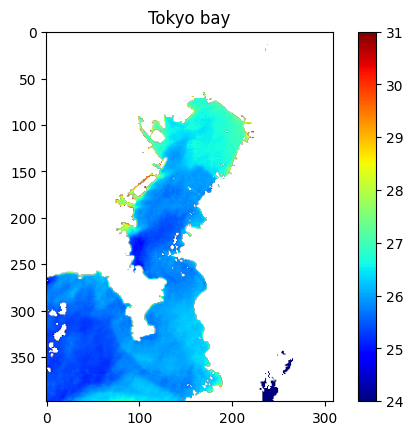

In [13]:
# Define latitude and longitude limits
lat_min = 35.0
lat_max = 35.8
lon_min = 139.5
lon_max = 140.2

# Identify target area within specified latitude and longitude range
tgt_area = (LLroi['Lat'] > lat_min) & (LLroi['Lat'] < lat_max) & (LLroi['Lon'] > lon_min) & (LLroi['Lon'] < lon_max)

# Find the row indices where any value in the row satisfies the condition
tgt_pix = np.where(np.sum(tgt_area, axis=1) > 0)[0]

# Find the column indices where any value in the column satisfies the condition
tgt_lin = np.where(np.sum(tgt_area, axis=0) > 0)[0]

# Get the min and max indices for rows and columns
pix_min = tgt_pix[0]
pix_max = tgt_pix[-1]
lin_min = tgt_lin[0]
lin_max = tgt_lin[-1]

# Extract the sub-set of lat and lon within the target area
tgt_lat = LLroi['Lat'][pix_min:pix_max+1, lin_min:lin_max+1]
tgt_lon = LLroi['Lon'][pix_min:pix_max+1, lin_min:lin_max+1]

# Extract the corresponding data
tgt_data0 = Data1[pix_min:pix_max+1, lin_min:lin_max+1]

# Plotting
fig, ax = plt.subplots()
plt.imshow(tgt_data0, cmap='jet', vmin=24, vmax=31)
ax.set_title("Tokyo bay")
plt.colorbar()
#plt.savefig("DN.png", format="png", dpi=2000)
plt.show()


## 5.3 Set resolution after map projection
Create a grid after map projection. Here, try map projection at **0.0025 [deg]** intervals.  
0.0025 deg is roughly 250 m.

In [14]:
ddeg = 0.0025

# Create latitude and longitude grids with specified resolution ddeg
latg = np.arange(lat_max, lat_min - ddeg, -ddeg)
long = np.arange(lon_min, lon_max + ddeg, ddeg)

# Generate a grid for map projection
llg_lat, llg_lon = np.meshgrid(latg, long, indexing='ij')

## 5.4 Projection to latitude and longitude coordinates
Convert to equirectangular coordinates using the griddata function

In [15]:
points = np.column_stack((tgt_lat.flatten(), tgt_lon.flatten()))
values = tgt_data0.flatten()

# Interpolate data over the new grid
Data2 = griddata(points, values, (llg_lat, llg_lon), method='linear')

Check that the map projection is correct.

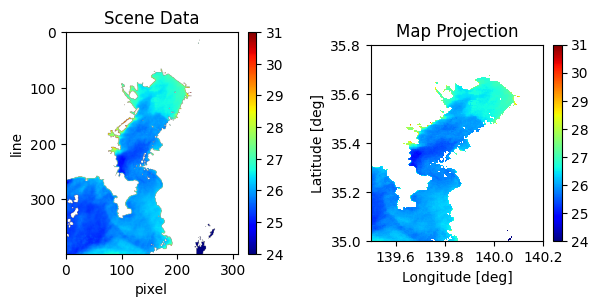

In [16]:
# Plotting
fig = plt.figure()
plt.subplots_adjust(wspace=0.6, hspace=0.6)

# First subplot: original data
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Scene Data")
ax1.set_xlabel('pixel')
ax1.set_ylabel('line')
im1 = ax1.imshow(tgt_data0, vmin=24, vmax=31, cmap='jet')
ax1.set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax)

# Second subplot: interpolated data in map projection
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Map Projection")
ax2.set_xlabel('Longitude [deg]')
ax2.set_ylabel('Latitude [deg]')
im2 = ax2.pcolormesh(long, latg, Data2, vmin=24, vmax=31, cmap='jet')
ax2.set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im2, cax=cax)

plt.show()

# 6. Exercise. Comparison between different sensors using map projections
Map-project the Chl-a images of the different sensors, SGLI and MODIS respectively, to see the differences.  
The different orbits and fields of view of MODIS and SGLI make it difficult to compare their spatial distribution using scene images.   
Therefore, map projection onto equirectangular coordinates should facilitate comparison of spatial distributions and create spatial deviations and scatter plots.

### 6.0 Import libraries

In [17]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable

## 6.1 SGLI FILE
Let's start with a map projection of the SGLI Chl-a image for review.


### 6.1.1 Check the structure of the hdf5 file

In [18]:
SGLI_FNAME = "PORSEC_2025/sample_images/GC1SG1_201910130153P05810_L2SG_IWPRK_3000.h5"
def PrintAllObjects(name):
    print(name)

with h5py.File(SGLI_FNAME,'r') as f:
    f.visit(PrintAllObjects)

Geometry_data
Geometry_data/Latitude
Geometry_data/Longitude
Geometry_data/Obs_time
Geometry_data/Sensor_azimuth
Geometry_data/Sensor_zenith
Geometry_data/Solar_azimuth
Geometry_data/Solar_zenith
Global_attributes
Image_data
Image_data/CDOM
Image_data/CHLA
Image_data/Line_tai93
Image_data/QA_flag
Image_data/TSM
Level_1_attributes
Processing_attributes


### 6.1.2 Dataname specification and checking the attribute

In [20]:
DNAME = '/Image_data/CHLA'

with h5py.File(SGLI_FNAME,'r') as file:
    dset = file[DNAME].attrs
    for k in dset.keys():
        print(k)

Data_description
Dim0
Dim1
Error_DN
Mask_for_statistics
Maximum_valid_DN
Minimum_valid_DN
Offset
Slope
Unit


### 6.1.3 Conversion from DN to physical quantity

In [21]:
with h5py.File(SGLI_FNAME, 'r') as file:
    # Read DN
    SGLI_Data0 = file[DNAME][:]

    # Read attributes
    Err_DN = file[DNAME].attrs['Error_DN']
    Min_DN = file[DNAME].attrs['Minimum_valid_DN']
    Max_DN = file[DNAME].attrs['Maximum_valid_DN']
    Slope  = file[DNAME].attrs['Slope']
    Offset = file[DNAME].attrs['Offset']

    # Removal of invalid pixels and physical quantity conversion.
    SGLI_Data1 = SGLI_Data0.astype(float)
    SGLI_Data1[SGLI_Data1 == Err_DN] = np.nan
    SGLI_Data1[(SGLI_Data1 <= Min_DN) | (SGLI_Data1 >= Max_DN)] = np.nan
    SGLI_Data1 = Slope * SGLI_Data1 + Offset

### 6.1.4 Applying the QA_flag

Check information of QA_flag

In [22]:
with h5py.File(SGLI_FNAME,'r') as file:
    qa_flag_data_description = file['/Image_data/QA_flag'].attrs['Data_description']
    qa_string = qa_flag_data_description.astype(str)
    qa_string = ",".join(qa_string)
    qa_string = qa_string.replace(',', '\n')
    print(qa_string)

Bit-0) DATAMISS: No observation data in one or more band[s]

Bit-1) LAND: Land pixel

Bit-2) ATMFAIL: Atmospheric correction failure

Bit-3) CLDICE: Apparent cloud/ice (high reflectance)

Bit-4) CLDAFFCTD: Cloud-affected (near-cloud or thin/sub-pixel cloud)

Bit-5) STRAYLIGHT: Stray light anticipated (ref. L1B stray light flags & image)

Bit-6) HIGLINT: High sun glint predicted (atmospheric corr. abandoned)

Bit-7) MODGLINT: Moderate glint predicted (correction applied)

Bit-8) HISOLZ: Solar zenith larger than threshold

Bit-9) HITAUA: Aerosol optical thickness larger than threshold

Bit-10) NEGNLW: Negative nLw in one or more bands

Bit-11) SPARE: 

Bit-12) SHALLOW: Shallow water than threshold

Bit-13) ITERFAILCDOM: Iteration failure for CDOM algorithm

Bit-14) CHLWARN: Chlorophyll a estimate out of range

Bit-15) SPARE: 




Apply the QA_flag mask

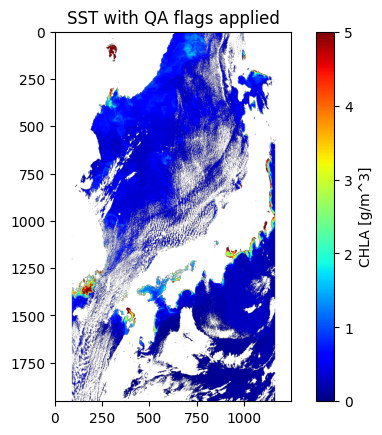

In [23]:
with h5py.File(SGLI_FNAME, 'r') as file:

    # Read QA_flag and cast to uint16
    QA_flag = file['/Image_data/QA_flag'][:].astype(np.uint16)

    # Extract bits safely (0〜15bit)
    bits = [(QA_flag & (1 << i)) for i in range(16)]

    # If you want to use different names (optional)
    bit00, bit01, bit02, bit03, bit04, bit05, bit06, bit07, \
    bit08, bit09, bit10, bit11, bit12, bit13, bit14, bit15 = bits

    # Create a QA mask (exclude the parts where bit 0 and bit 1 are set)
    mask = np.logical_or.reduce([
        bit00 != 0,
        bit01 != 0
        # Add bit02 to bit15 as needed
    ])
    # Apply QA_flag mask
    SGLI_Data1[mask] = np.nan

    # Plotting with reliability mask
    fig, ax = plt.subplots()
    plt.imshow(SGLI_Data1, cmap='jet', vmin=0, vmax=5)
    ax.set_title("SST with QA flags applied")
    plt.colorbar(label='CHLA [g/m^3]')
    plt.show()

### 6.1.5 Reading latitude and longitude

In [24]:
chunk_size = 500  # Chunk size for rows (The chunk size is smaller this time because 1 km resolution is used.)

with h5py.File(SGLI_FNAME, 'r') as file:
    Data0_shape = file[DNAME].shape
    Lat_shape = file['/Geometry_data/Latitude'].shape
    Lon_shape = file['/Geometry_data/Longitude'].shape

    Lat = file['/Geometry_data/Latitude'][:]
    Lon = file['/Geometry_data/Longitude'][:]

    Lat_r = float(file['/Geometry_data/Latitude'].attrs['Resampling_interval'])
    Lon_r = float(file['/Geometry_data/Longitude'].attrs['Resampling_interval'])

    # Create meshgrid for the original Latitude and Longitude data
    X, Y = np.meshgrid(np.arange(0, Lat_r * Lat_shape[1], Lat_r),
                       np.arange(0, Lat_r * Lat_shape[0], Lat_r))

    # Prepare output arrays for interpolated Latitude and Longitude
    f_lat = np.empty(Data0_shape, dtype=np.float32)
    f_lon = np.empty(Data0_shape, dtype=np.float32)

    # Process data in chunks
    for start_row in range(0, Data0_shape[0], chunk_size):
        end_row = min(start_row + chunk_size, Data0_shape[0])

        # Create query meshgrid corresponding to the Data0 shape for this chunk
        Xq, Yq = np.meshgrid(np.arange(0, Data0_shape[1]),
                             np.arange(start_row, end_row))

        # Convert Latitude and Longitude indices to integers
        start_row_geo = int(start_row / 10)
        end_row_geo = int(end_row / 10) + 1

        # Flatten the X, Y for interpolation
        points = np.column_stack([X[start_row_geo:end_row_geo, :].flatten(), Y[start_row_geo:end_row_geo, :].flatten()])

        # Slice using Latitude and Longitude indices
        lat_chunk = file['/Geometry_data/Latitude'][start_row_geo:end_row_geo, :].flatten()
        lon_chunk = file['/Geometry_data/Longitude'][start_row_geo:end_row_geo, :].flatten()

        # Interpolate Latitude and Longitude for the current chunk
        f_lat[start_row:end_row, :] = griddata(points, lat_chunk, (Xq, Yq), method='linear')
        f_lon[start_row:end_row, :] = griddata(points, lon_chunk, (Xq, Yq), method='linear')

    LLroi = {'Lat': f_lat, 'Lon': f_lon}

<ipython-input-24-7654efd192ef>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Lat_r = float(file['/Geometry_data/Latitude'].attrs['Resampling_interval'])
<ipython-input-24-7654efd192ef>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Lon_r = float(file['/Geometry_data/Longitude'].attrs['Resampling_interval'])


Check for accurate interpolation.

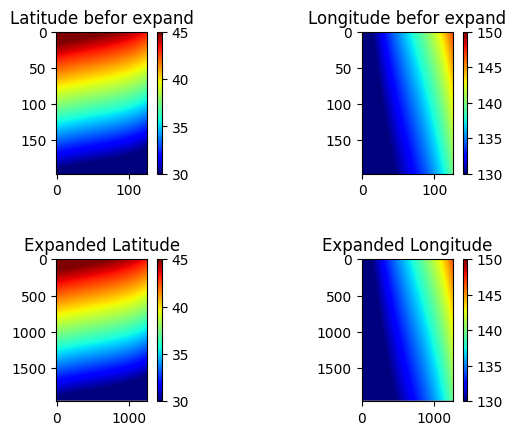

In [25]:
# Plotting
fig = plt.figure()
plt.subplots_adjust(wspace=0.6, hspace=0.6)

ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title("Latitude befor expand")
im1 = ax1.imshow(Lat, vmin=30, vmax=45, cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax)

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title("Longitude befor expand")
im2 = ax2.imshow(Lon, vmin=130, vmax=150, cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im2, cax=cax)

ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title("Expanded Latitude")
im3 = ax3.imshow(LLroi['Lat'], vmin=30, vmax=45, cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im3, cax=cax)

ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title("Expanded Longitude")
im4 = ax4.imshow(LLroi['Lon'], vmin=130, vmax=150, cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im4, cax=cax)

plt.show()

### 6.1.6 Cut out target area
This time, the area of the Kanto coast is targeted and cut out.

In [26]:
# Define latitude and longitude limits
lat_min = 34.5
lat_max = 36.5
lon_min = 138
lon_max = 141

# Identify target area within specified latitude and longitude range
tgt_area = (LLroi['Lat'] > lat_min) & (LLroi['Lat'] < lat_max) & (LLroi['Lon'] > lon_min) & (LLroi['Lon'] < lon_max)

# Find the row indices where any value in the row satisfies the condition
tgt_pix = np.where(np.sum(tgt_area, axis=1) > 0)[0]

# Find the column indices where any value in the column satisfies the condition
tgt_lin = np.where(np.sum(tgt_area, axis=0) > 0)[0]

# Get the min and max indices for rows and columns
pix_min = tgt_pix[0]
pix_max = tgt_pix[-1]
lin_min = tgt_lin[0]
lin_max = tgt_lin[-1]

# Extract the sub-set lat and lon within the target area
tgt_lat = LLroi['Lat'][pix_min:pix_max+1, lin_min:lin_max+1]
tgt_lon = LLroi['Lon'][pix_min:pix_max+1, lin_min:lin_max+1]

# Extract the corresponding data
tgt_data0 = SGLI_Data1[pix_min:pix_max+1, lin_min:lin_max+1]

### 6.1.7 Set resolution after map projection
Create a grid after map projection. Here, try map projection at **0.01 [deg]** intervals.  
0.01 deg is roughly 1 km.

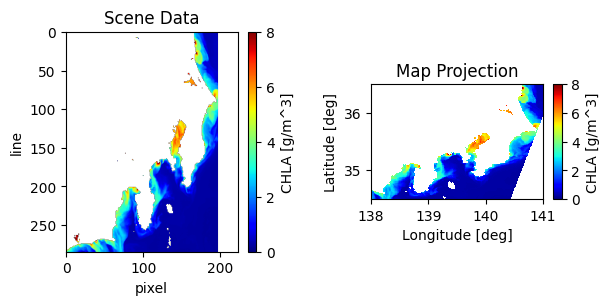

In [27]:
ddeg = 0.01

# Create latitude and longitude grids with specified resolution ddeg
latg = np.arange(lat_max, lat_min - ddeg, -ddeg)
long = np.arange(lon_min, lon_max + ddeg, ddeg)

# Generate a grid for map projection
llg_lat, llg_lon = np.meshgrid(latg, long, indexing='ij')

# Interpolation using griddata
points = np.column_stack((tgt_lat.flatten(), tgt_lon.flatten()))
values = tgt_data0.flatten()

# Interpolate data over the new grid
SGLI_Data2 = griddata(points, values, (llg_lat, llg_lon), method='linear')
# Plotting
fig = plt.figure()
plt.subplots_adjust(wspace=0.6, hspace=0.6)

# First subplot: original data
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Scene Data")
ax1.set_xlabel('pixel')
ax1.set_ylabel('line')
im1 = ax1.imshow(tgt_data0, vmin=0, vmax=8, cmap='jet')
ax1.set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax,label='CHLA [g/m^3]')

# Second subplot: interpolated data in map projection
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Map Projection")
ax2.set_xlabel('Longitude [deg]')
ax2.set_ylabel('Latitude [deg]')
im2 = ax2.pcolormesh(long, latg, SGLI_Data2, vmin=0, vmax=8, cmap='jet')
ax2.set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im2, cax=cax,label='CHLA [g/m^3]')

plt.show()

## 6.2 MODIS FILE
Then load the MODIS Chl-a data and map projection in the same way as for SGLI.
### 6.2.1 Check the structure of the netCDF file
MODIS satellite data is distributed in netCDF format not hdf5 format.  
The basic handling is the same, but there are a few points to note, which will be explained later.  
First, let's look at the file structure.

In [28]:
MODIS_FNAME = "PORSEC_2025/sample_images/AQUA_MODIS.20191013T035001.L2.OC.nc"
def PrintAllObjects(name):
    print(name)

with h5py.File(MODIS_FNAME,'r') as f:
    f.visit(PrintAllObjects)

bands_per_pixel
geophysical_data
geophysical_data/Kd_490
geophysical_data/Rrs_412
geophysical_data/Rrs_443
geophysical_data/Rrs_469
geophysical_data/Rrs_488
geophysical_data/Rrs_531
geophysical_data/Rrs_547
geophysical_data/Rrs_555
geophysical_data/Rrs_645
geophysical_data/Rrs_667
geophysical_data/Rrs_678
geophysical_data/angstrom
geophysical_data/aot_869
geophysical_data/chlor_a
geophysical_data/ipar
geophysical_data/l2_flags
geophysical_data/nflh
geophysical_data/par
geophysical_data/pic
geophysical_data/poc
navigation_data
navigation_data/cntl_pt_cols
navigation_data/cntl_pt_rows
navigation_data/latitude
navigation_data/longitude
navigation_data/tilt
number_of_bands
number_of_lines
number_of_reflectance_location_values
number_of_reflective_bands
pixel_control_points
pixels_per_line
processing_control
processing_control/flag_percentages
processing_control/input_parameters
scan_line_attributes
scan_line_attributes/clat
scan_line_attributes/clon
scan_line_attributes/csol_z
scan_line_at

### 6.2.2 Read dataset
Files in netCDF format, such as MODIS, have slope and offset automatically applied when loaded in python.

In [29]:
DNAME = '/geophysical_data/chlor_a'
with h5py.File(MODIS_FNAME, 'r') as file:
    # Read dataset
    MODIS_Data0 = file[DNAME][:]

### 6.2.3 Check QA_flag meanings

In [30]:
with h5py.File(MODIS_FNAME,'r') as file:
    qa_flag_data_description = file['/geophysical_data/l2_flags'].attrs['flag_meanings']
    qa_string = qa_flag_data_description.astype(str)
    qa_string = qa_string.replace(' ', '\n')
    print(qa_string)

ATMFAIL
LAND
PRODWARN
HIGLINT
HILT
HISATZEN
COASTZ
SPARE
STRAYLIGHT
CLDICE
COCCOLITH
TURBIDW
HISOLZEN
SPARE
LOWLW
CHLFAIL
NAVWARN
ABSAER
SPARE
MAXAERITER
MODGLINT
CHLWARN
ATMWARN
SPARE
SEAICE
NAVFAIL
FILTER
SPARE
BOWTIEDEL
HIPOL
PRODFAIL
SPARE


### 6.2.4 Applying the QA_flag
As can be seen from the attribute, there are 32 QA_FLAGs in MODIS.   
The QA flags of MODIS are stored in DN (-2147483648:2147483648) and the flag corresponding to the value of each bit when viewed as a binary number (type int32) is set.   

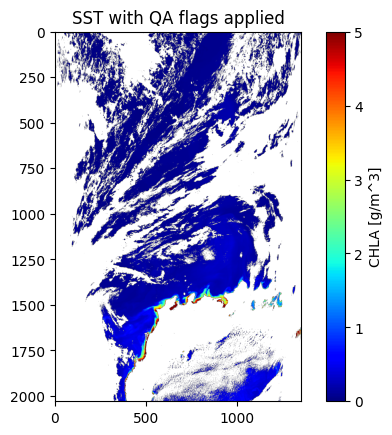

In [31]:
with h5py.File(MODIS_FNAME, 'r') as file:

    # Read QA_flag and cast to uint32
    QA_flag = file['/geophysical_data/l2_flags'][:].astype(np.uint32)

    # Extract all 32 bits safely
    bits = [(QA_flag & (1 << i)) for i in range(32)]

    # Optional: unpack if you want bit00, bit01... as separate variables
    bit00, bit01, bit02, bit03, bit04, bit05, bit06, bit07, \
    bit08, bit09, bit10, bit11, bit12, bit13, bit14, bit15, \
    bit16, bit17, bit18, bit19, bit20, bit21, bit22, bit23, \
    bit24, bit25, bit26, bit27, bit28, bit29, bit30, bit31 = bits

    # Choose which bits to mask out
    mask = np.logical_or.reduce([
        bit00 != 0,
        bit01 != 0
        # ← Add another bit as needed
    ])

    # Apply reliability mask
    MODIS_Data0[mask] = np.nan
    MODIS_Data0[MODIS_Data0<0] = np.nan

    # Plotting with reliability mask
    fig, ax = plt.subplots()
    plt.imshow(MODIS_Data0, cmap='jet', vmin=0, vmax=5)
    ax.set_title("SST with QA flags applied")
    plt.colorbar(label='CHLA [g/m^3]')
    plt.show()

### 6.2.5 Cut out target area
Cut out the same area as the SGLI.

In [32]:
# Define latitude and longitude limits
lat_min = 34.5
lat_max = 36.5
lon_min = 138
lon_max = 141

with h5py.File(MODIS_FNAME, 'r') as file:
    MODIS_lat = file["/navigation_data/latitude"][:]
    MODIS_lon = file["/navigation_data/longitude"][:]
    tgt_area = (MODIS_lat > lat_min) & (MODIS_lat < lat_max) & (MODIS_lon > lon_min) & (MODIS_lon < lon_max)
    # Find the row indices where any value in the row satisfies the condition
    tgt_pix = np.where(np.sum(tgt_area, axis=1) > 0)[0]
    # Find the column indices where any value in the column satisfies the condition
    tgt_lin = np.where(np.sum(tgt_area, axis=0) > 0)[0]

    # Get the min and max indices for rows and columns
    pix_min = tgt_pix[0]
    pix_max = tgt_pix[-1]
    lin_min = tgt_lin[0]
    lin_max = tgt_lin[-1]

    # Extract the sub-region of lat and lon within the target area
    tgt_lat = MODIS_lat[pix_min:pix_max+1, lin_min:lin_max+1]
    tgt_lon = MODIS_lon[pix_min:pix_max+1, lin_min:lin_max+1]

    # Assuming data0 is a NumPy array, extract the corresponding data
    tgt_data0 = MODIS_Data0[pix_min:pix_max+1, lin_min:lin_max+1]

### 6.2.6 Set resolution after map projection
Map projection with the same resolution(**0.01 [deg]**) as SGLI.

In [33]:
ddeg = 0.01

# Create latitude and longitude grids with specified resolution ddeg
latg = np.arange(lat_max, lat_min - ddeg, -ddeg)
long = np.arange(lon_min, lon_max + ddeg, ddeg)

# Generate a grid for map projection
llg_lat, llg_lon = np.meshgrid(latg, long, indexing='ij')

# Interpolation using griddata
points = np.column_stack((tgt_lat.flatten(), tgt_lon.flatten()))
values = tgt_data0.flatten()

# Interpolate data over the new grid
MODIS_Data2 = griddata(points, values, (llg_lat, llg_lon), method='linear')

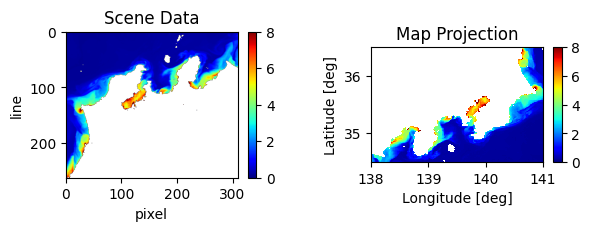

In [34]:
# Plotting
fig = plt.figure()
plt.subplots_adjust(wspace=0.6, hspace=0.6)

# First subplot: original data
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Scene Data")
ax1.set_xlabel('pixel')
ax1.set_ylabel('line')
im1 = ax1.imshow(tgt_data0, vmin=0, vmax=8, cmap='jet')
ax1.set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax)

# Second subplot: interpolated data in map projection
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Map Projection")
ax2.set_xlabel('Longitude [deg]')
ax2.set_ylabel('Latitude [deg]')
im2 = ax2.pcolormesh(long, latg, MODIS_Data2, vmin=0, vmax=8, cmap='jet')
ax2.set_aspect('equal', adjustable='box')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im2, cax=cax)

plt.show()

## 6.3 Difference between SGLI and MODIS Chl-a estimates
Let's now visualize the deviation of Chl-a for SGLI and MODIS with the same extent and resolution of the map projection.

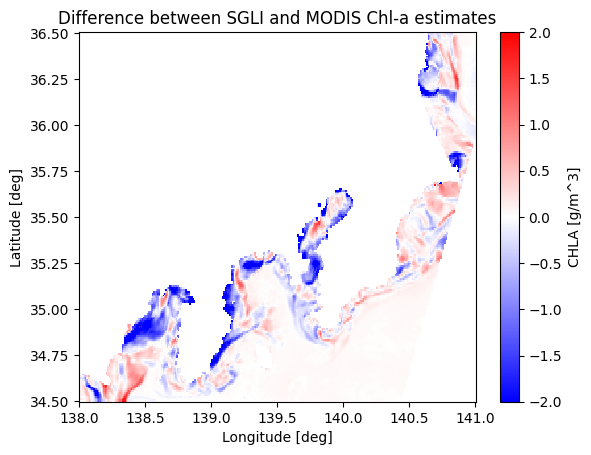

In [35]:
difference = SGLI_Data2 - MODIS_Data2

# Second subplot: interpolated data in map projection
fig, ax = plt.subplots()
plt.set_cmap('bwr')
#plt.imshow(difference, cmap='jet', vmin=0, vmax=5)
plt.pcolor(long, latg, difference, vmin=-2, vmax=2)
ax.set_title("Difference between SGLI and MODIS Chl-a estimates")
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
plt.colorbar(label='CHLA [g/m^3]')
plt.show()

The day was right after a typhoon had passed, and due to river flooding, a large amount of suspended matter flowed into the coastal area. As a result, it can be seen that the spatial distribution differs significantly between SGLI and MODIS, given the about three-hour difference in observation times

## 6.4 Histogram and scatter plots
As the resolution is the same, it can also be used to create histograms and scatter plots.

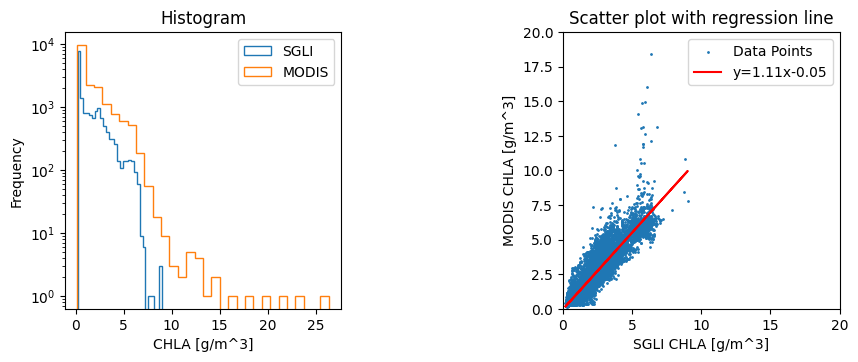

In [36]:
valid_mask = ~np.isnan(SGLI_Data2) & ~np.isnan(MODIS_Data2)  # Masking of data not containing NaN

SGLI_valid = SGLI_Data2[valid_mask]
MODIS_valid = MODIS_Data2[valid_mask]

# Plotting
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0.8, hspace=0.4)

# First subplot: original data (histogram)
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(SGLI_valid.flatten(), bins=30, label='SGLI', log=True, histtype="step")
ax1.hist(MODIS_valid.flatten(), bins=30, label='MODIS', log=True, histtype="step")

ax1.set_title("Histogram")
ax1.set_xlabel('CHLA [g/m^3]')
ax1.set_ylabel('Frequency')
ax1.legend(loc='upper right')
ax1.set_aspect(1.0 / ax1.get_data_ratio())

# Second subplot: scatter plot with regression line
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(SGLI_valid, MODIS_valid, s=1, label='Data Points')

# Perform linear regression on valid data only
slope, intercept = np.polyfit(SGLI_valid.flatten(), MODIS_valid.flatten(), 1)
reg_line = slope * SGLI_valid + intercept

# Plot the regression line
if intercept >= 0:
    ax2.plot(SGLI_valid, reg_line, color='red', label=f'y={slope:.2f}x+{intercept:.2f}')
else:
    ax2.plot(SGLI_valid, reg_line, color='red', label=f'y={slope:.2f}x{intercept:.2f}')

ax2.set_xlim(0,20)
ax2.set_ylim(0,20)

ax2.set_title("Scatter plot with regression line")
ax2.set_xlabel('SGLI CHLA [g/m^3]')
ax2.set_ylabel('MODIS CHLA [g/m^3]')
ax2.legend()

# Make the plot square
ax2.set_aspect(1.0 / ax2.get_data_ratio())

plt.show()

Looking at the histogram, the SGLI data is relatively concentrated at lower concentrations compared to MODIS.  
It can also be observed that MODIS has a higher number of valid pixels.  
The scatter plot reflects this, showing a slope of 1.1 for the regression line, indicating that MODIS estimates relatively higher values compared to SGLI.